In [19]:
import cv2
import numpy as np
import time
import imageio.v3 as iio
import os
import gphoto2 as gp
import matplotlib.pyplot as plt

def downsample_image(image, downsample_factor=2):
    """
    Downsample the image by the provided factor.
    """
    # Calculate the new dimensions
    new_width = image.shape[1] // downsample_factor
    new_height = image.shape[0] // downsample_factor
    
    # Downsample the image
    downsampled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    return downsampled_image

# Load the image
def capture_image():
    t1 = time.time()
    camera = gp.Camera()
    camera.init()
    # print('Capturing image')
    file_path = camera.capture(gp.GP_CAPTURE_IMAGE)
    # print('Camera file path: {0}/{1}'.format(file_path.folder, file_path.name))
    target = os.path.join('/tmp', file_path.name)
    # print('Copying image to', target)
    camera_file = camera.file_get(
        file_path.folder, file_path.name, gp.GP_FILE_TYPE_NORMAL)
    camera_file.save(target)
    img = iio.imread(target)
    # print(img.shape)
    # plt.imshow(img)
    # plt.show()
    camera.exit()
    t2 = time.time()
    # print("Time took {} seconds".format(t2 - t1))
    return img

def process_image(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Use Gaussian blur to reduce noise and improve dot detection
    blurred = cv2.GaussianBlur(gray_image, (9, 9), 0)
    
    # Threshold the image to create a binary image where the dots are white
    _, binary_image = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)
    # plt.imshow(binary_image)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    
    # Calculate the weighted average position of the contours
    dot_pixel_locations = []
    for contour in contours:
        # Calculate the center of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            dot_pixel_locations.append((cX, cY))
    
    return dot_pixel_locations

# Process the image to find the dots
img = downsample_image(capture_image(), 2)

dot_pixel_locations = process_image(img)

# The number of detected dots should be printed out
len(dot_pixel_locations), dot_pixel_locations


(34,
 [(1241, 1588),
  (1505, 1582),
  (1764, 1578),
  (974, 1399),
  (1505, 1401),
  (1238, 1400),
  (1770, 1395),
  (2023, 1384),
  (1505, 1206),
  (1234, 1206),
  (971, 1204),
  (1774, 1202),
  (2273, 1186),
  (2029, 1193),
  (1232, 1006),
  (969, 1005),
  (1504, 1003),
  (1775, 1002),
  (2032, 997),
  (2277, 993),
  (966, 804),
  (2278, 798),
  (1232, 802),
  (2031, 798),
  (1503, 799),
  (1774, 797),
  (963, 601),
  (2031, 600),
  (1234, 601),
  (1771, 597),
  (1504, 597),
  (1232, 398),
  (1768, 397),
  (1502, 397)])

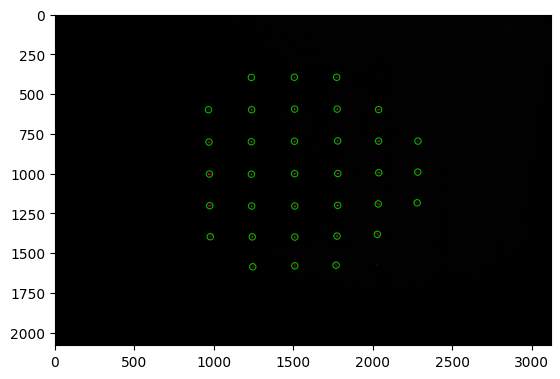

In [20]:
image_with_dots = img.copy()

# Draw a red circle around each dot
for (x, y) in dot_pixel_locations:
    cv2.circle(image_with_dots, (x, y), 20, (0, 255, 0), 4)

plt.imshow(image_with_dots)